# Education in Slovakia

## Import packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go

from IPython.display import display
import preprocessing

import os
import warnings
# TODO: uncomment before publishing
#warnings.filterwarnings('ignore')

## Import data

In [2]:
table_010_SK = pd.read_csv(
    'https://raw.githubusercontent.com/AndruKP/mathprofi-education/dev/data/RV_O_010_R_SR_SK.CSV', sep=';')
table_040_SK = pd.read_csv(
    'https://raw.githubusercontent.com/AndruKP/mathprofi-education/dev/data/RV_O_040_R_SR_SK.CSV', sep=';')

display(table_010_SK.head())
display(table_040_SK.head())

,Kód štátu,Názov štátu,Pohlavie,Ekonomické vekové skupiny,Vzdelanie,abs.
0,SK0,Slovenská republika,muž,predproduktívny vek (0-14 rokov),nezistené,6301
1,SK0,Slovenská republika,muž,predproduktívny vek (0-14 rokov),základné vzdelanie (bližšie neuvedené),1
2,SK0,Slovenská republika,muž,predproduktívny vek (0-14 rokov),základné vzdelanie - 1. stupeň základnej školy,117157
3,SK0,Slovenská republika,muž,predproduktívny vek (0-14 rokov),základné vzdelanie - 2. stupeň základnej školy,66
4,SK0,Slovenská republika,muž,predproduktívny vek (0-14 rokov),bez ukončeného vzdelania – osoby vo veku 0-14 ...,320751


,Kód štátu,Názov štátu,Pohlavie,Vek,Vzdelanie,Súčasná ekonomická aktivita,abs.
0,SK0,Slovenská republika,muž,0,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,29036
1,SK0,Slovenská republika,muž,1,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,30033
2,SK0,Slovenská republika,muž,2,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,30808
3,SK0,Slovenská republika,muž,3,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,31100
4,SK0,Slovenská republika,muž,4,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,30873


## Preprocess data

In [3]:
# TODO: aggregate all preprocessing functions into one

table_010_SK = preprocessing.rename_columns(table_010_SK)
table_040_SK = preprocessing.rename_columns(table_040_SK)

table_010_SK = preprocessing.translate_sex(table_010_SK)
table_040_SK = preprocessing.translate_sex(table_040_SK)

table_040_SK.age = table_040_SK.age.apply(preprocessing.age_preprocess)

display(table_010_SK.head())
display(table_040_SK.head())

,NUTS1_CODE,state_name,sex,economical_age_groups,education,count
0,SK0,Slovenská republika,male,predproduktívny vek (0-14 rokov),nezistené,6301
1,SK0,Slovenská republika,male,predproduktívny vek (0-14 rokov),základné vzdelanie (bližšie neuvedené),1
2,SK0,Slovenská republika,male,predproduktívny vek (0-14 rokov),základné vzdelanie - 1. stupeň základnej školy,117157
3,SK0,Slovenská republika,male,predproduktívny vek (0-14 rokov),základné vzdelanie - 2. stupeň základnej školy,66
4,SK0,Slovenská republika,male,predproduktívny vek (0-14 rokov),bez ukončeného vzdelania – osoby vo veku 0-14 ...,320751


,NUTS1_CODE,state_name,sex,age,education,current_economic_activity,count
0,SK0,Slovenská republika,male,0,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,29036
1,SK0,Slovenská republika,male,1,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,30033
2,SK0,Slovenská republika,male,2,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,30808
3,SK0,Slovenská republika,male,3,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,31100
4,SK0,Slovenská republika,male,4,bez ukončeného vzdelania – osoby vo veku 0-14 ...,dieťa do začatia povinnej školskej dochádzky,30873


## Basic demographic analysis

### Population pyramid

In [4]:
grouped_by_sex_age = table_040_SK.groupby(['sex', 'age'])['count'].sum()
women_counts = grouped_by_sex_age.loc['female']
men_counts = -1 * grouped_by_sex_age.loc['male']

C:\Users\andru_kfgnofp\anaconda3\envs\mathprofi-education\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\andru_kfgnofp\anaconda3\envs\mathprofi-education\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


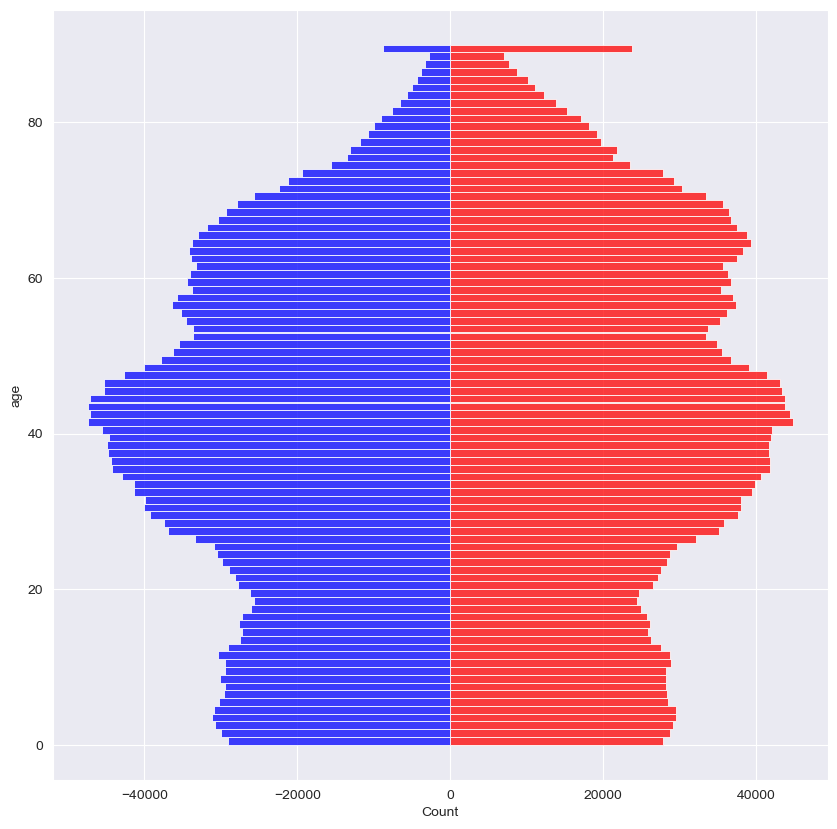

In [5]:
# TODO: legend and beauty
figure, axes = plt.subplots(figsize=(10, 10))

sns.histplot(y=women_counts.index, weights=women_counts, binwidth=1, color='red')
sns.histplot(y=men_counts.index, weights=men_counts, binwidth=1, color='blue')
pass

### Education specialization

In [6]:
# TODO: someone's data (Sasha's idk)

In [7]:
# TODO: someone's graph (barplot idk)

### Employment specialization

In [8]:
# TODO: someone's data (Sasha's idk)

In [9]:
# TODO: someone's graph (barplot idk)

### Geographic specialization of education

In [10]:
# TODO: Kolya's data

In [11]:
# TODO: Kolya's graphs

### Gender specialization of education with respect to age

In [12]:
# TODO: first hypothesis by Filip Kerak

### Uneducated population

In [13]:
# TODO: Romani people hypothesis